# Part 1: Dataset Preparation

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
print(torch.backends.mps.is_available())  # Should return True
print(torch.device('mps'))  # Device type

True
mps


In [4]:
# Define transformations (normalization values from CIFAR-10 docs)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Download full CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")
full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

In [5]:
# Function to create subsets with different sizes per class
def create_subset(dataset, samples_per_class):
    class_indices = [[] for _ in range(10)]  # CIFAR-10 has 10 classes
    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)
    return Subset(dataset, [idx for sublist in class_indices for idx in sublist])

# Create subsets (500, 1000, 5000 images per class)
print("\nCreating subsets...")
subset_500 = create_subset(full_trainset, 50)    # 50 per class → 500 total
subset_1000 = create_subset(full_trainset, 100)  # 100 per class → 1000 total
subset_5000 = create_subset(full_trainset, 500)  # 500 per class → 5000 total

# Create dataloaders
batch_size = 128
train_loaders = {
    '500': DataLoader(subset_500, batch_size=batch_size, shuffle=True, num_workers=2),
    '1000': DataLoader(subset_1000, batch_size=batch_size, shuffle=True, num_workers=2),
    '5000': DataLoader(subset_5000, batch_size=batch_size, shuffle=True, num_workers=2)
}
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)



Creating subsets...


In [6]:
# Function to verify the distribution of classes in a subset
def verify_subset_distribution(subset):
    class_counts = [0] * 10
    for _, label in subset:
        class_counts[label] += 1
    print("Class distribution:", class_counts)
    print("Total samples:", sum(class_counts))

# Verify the subsets
print("\nVerifying subset distributions:")
for size, loader in train_loaders.items():
    print(f"\nSubset with {size} images per class:")
    verify_subset_distribution(loader.dataset)

print("\nTest set distribution:")
verify_subset_distribution(test_loader.dataset)

print("\nDataset preparation complete! You can now use:")
print("- train_loaders['500'], train_loaders['1000'], train_loaders['5000'] for training")
print("- test_loader for evaluation")


Verifying subset distributions:

Subset with 500 images per class:
Class distribution: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Total samples: 500

Subset with 1000 images per class:
Class distribution: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Total samples: 1000

Subset with 5000 images per class:
Class distribution: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
Total samples: 5000

Test set distribution:
Class distribution: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Total samples: 10000

Dataset preparation complete! You can now use:
- train_loaders['500'], train_loaders['1000'], train_loaders['5000'] for training
- test_loader for evaluation


# Part 2: Model Architecture Comparison

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
# Check for GPU

### Define train and evalulate

In [10]:

# Training Function
def train_and_evaluate(model, train_loader, test_loader, epochs=20, model_name="",learning_rate=0.001, device='mps'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training
    print(f"\nTraining {model_name}...")
    train_losses, test_losses, test_accs = [], [], []
    start_time = time.time()  # Track training time

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Record metrics
        epoch_train_loss = running_loss/len(train_loader)
        epoch_test_loss = test_loss/len(test_loader)
        epoch_test_acc = correct/total
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Test Loss: {test_losses[-1]:.4f} | "
              f"Test Acc: {100*test_accs[-1]:.2f}%")
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return {
        'name': model_name,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_accuracies': test_accs,
        'final_accuracy': test_accs[-1],
        'training_time': training_time
    }

## MLP (Multi-Layer Perceptron)

In [12]:
# PART 2: Model Architecture Definitions

# 1. MLP (Multi-Layer Perceptron)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        # Input: 3 x 32 x 32 = 3072
        self.layers = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

### Trainig MLP on all subsets 

In [14]:
 #Train MLP on all subsets
print("=== TRAINING PHASE (MLP) ===")
subset_sizes = ['500', '1000', '5000']
mlp_model = MLP()  # Create MLP model instance

mlp_results = {}  # Dictionary to store MLP results

for size in subset_sizes:
    print(f"\n{'='*50}")
    print(f"Training MLP on subset with {size} samples per class")
    print(f"{'='*50}")
    
    # Create fresh MLP instance for each training run
    model_instance = MLP()  
    
    # Train and evaluate, storing directly in mlp_results
    mlp_results[size] = train_and_evaluate(
        model_instance,
        train_loaders[size],  # Use specific subset loader
        test_loader,
        model_name=f"MLP ({size} samples)"
    )

# Verify MLP results structure
print("\nMLP Results Summary:")
for size, results in mlp_results.items():
    print(f"{size} samples - Accuracy: {results['final_accuracy']*100:.2f}%")

=== TRAINING PHASE (MLP) ===

Training MLP on subset with 500 samples per class

Training MLP (500 samples)...
Epoch 1/20 | Train Loss: 2.3076 | Test Loss: 2.1232 | Test Acc: 24.21%
Epoch 2/20 | Train Loss: 1.9314 | Test Loss: 2.1287 | Test Acc: 27.31%
Epoch 3/20 | Train Loss: 1.6520 | Test Loss: 2.0890 | Test Acc: 28.05%
Epoch 4/20 | Train Loss: 1.3978 | Test Loss: 2.0853 | Test Acc: 31.66%
Epoch 5/20 | Train Loss: 1.2021 | Test Loss: 2.1020 | Test Acc: 31.24%
Epoch 6/20 | Train Loss: 1.0065 | Test Loss: 2.1860 | Test Acc: 31.79%
Epoch 7/20 | Train Loss: 0.8162 | Test Loss: 2.2983 | Test Acc: 31.91%
Epoch 8/20 | Train Loss: 0.6645 | Test Loss: 2.4012 | Test Acc: 30.49%
Epoch 9/20 | Train Loss: 0.6086 | Test Loss: 2.5895 | Test Acc: 31.55%
Epoch 10/20 | Train Loss: 0.4383 | Test Loss: 2.8072 | Test Acc: 29.48%
Epoch 11/20 | Train Loss: 0.3749 | Test Loss: 2.8844 | Test Acc: 30.30%
Epoch 12/20 | Train Loss: 0.3333 | Test Loss: 2.8425 | Test Acc: 32.72%
Epoch 13/20 | Train Loss: 0.2911 |

### MLP Comparison Table

In [16]:
import pandas as pd

def generate_mlp_comparison_table(mlp_results, subset_sizes):
    table_data = []
    
    for size in subset_sizes:
        if size in mlp_results:  # Check if size exists in results
            res = mlp_results[size]  # Directly access the MLP results for this size
            table_data.append({
                'Model': 'MLP',  # Hardcoded since we're only analyzing MLP
                'Dataset Size': size,
                'Accuracy (%)': f"{res['final_accuracy']*100:.2f}",
                'Training Time (s)': f"{res['training_time']:.1f}",
                'Final Train Loss': f"{res['train_losses'][-1]:.4f}",
                'Final Test Loss': f"{res['test_losses'][-1]:.4f}",
                'Overfitting Gap': f"{res['train_losses'][-1] - res['test_losses'][-1]:.4f}"
            })
    
    return pd.DataFrame(table_data)

# Generate and display MLP-only table
mlp_comparison_table = generate_mlp_comparison_table(mlp_results, ['500', '1000', '5000'])
print(mlp_comparison_table.to_markdown(index=False))

| Model   |   Dataset Size |   Accuracy (%) |   Training Time (s) |   Final Train Loss |   Final Test Loss |   Overfitting Gap |
|:--------|---------------:|---------------:|--------------------:|-------------------:|------------------:|------------------:|
| MLP     |            500 |          31.31 |               496.6 |             0.0903 |            3.7701 |           -3.6798 |
| MLP     |           1000 |          33.53 |               496.5 |             0.2193 |            3.6953 |           -3.476  |
| MLP     |           5000 |          43.33 |               498.8 |             0.8145 |            2.0873 |           -1.2728 |


A Multi-Layer Perceptron (MLP) model trained on three different determined dataset size: 500, 1000 and 5000 samples. From the table we can see that generalization increases when dataset size is increased 31.31%  and 43.33%. The training time is fairly consistently approximately 496–499 seconds, and thus, the training time does not very much depend on data set size. The final training loss increases slightly as the size of data becomes larger, and the final test loss decreases as we have the effect of reduced overfitting gap—from -3.6798 to -1.2728. This suggests that as the dataset becomes larger, the model is becoming less overfit.

## CNN (Convolutional Neural Network) Model

In [18]:
# 2. CNN (Convolutional Neural Network)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### Trainig CNN on all subsets 

In [20]:
 #Train CNN on all subsets
print("=== TRAINING PHASE (CNN) ===")
subset_sizes = ['500', '1000', '5000']
cnn_model = CNN()  # Create cnn model instance

cnn_results = {}  # Dictionary to store cnn results

for size in subset_sizes:
    print(f"\n{'='*50}")
    print(f"Training CNN on subset with {size} samples per class")
    print(f"{'='*50}")
    
    # Create fresh CNN instance for each training run
    model_instance = CNN()  
    
    # Train and evaluate, storing directly in cvv_results
    cnn_results[size] = train_and_evaluate(
        model_instance,
        train_loaders[size],  # Use specific subset loader
        test_loader,
        model_name=f"CNN ({size} samples)"
    )

# Verify CNN results structure
print("\nCNN Results Summary:")
for size, results in cnn_results.items():
    print(f"{size} samples - Accuracy: {results['final_accuracy']*100:.2f}%")

=== TRAINING PHASE (CNN) ===

Training CNN on subset with 500 samples per class

Training CNN (500 samples)...
Epoch 1/20 | Train Loss: 2.2577 | Test Loss: 2.2307 | Test Acc: 25.65%
Epoch 2/20 | Train Loss: 1.5759 | Test Loss: 2.1058 | Test Acc: 27.71%
Epoch 3/20 | Train Loss: 1.2518 | Test Loss: 2.0110 | Test Acc: 25.34%
Epoch 4/20 | Train Loss: 0.9700 | Test Loss: 1.9463 | Test Acc: 28.15%
Epoch 5/20 | Train Loss: 0.6724 | Test Loss: 1.9021 | Test Acc: 28.44%
Epoch 6/20 | Train Loss: 0.4748 | Test Loss: 1.8269 | Test Acc: 32.53%
Epoch 7/20 | Train Loss: 0.3251 | Test Loss: 1.7271 | Test Acc: 36.80%
Epoch 8/20 | Train Loss: 0.1942 | Test Loss: 1.7416 | Test Acc: 37.78%
Epoch 9/20 | Train Loss: 0.1271 | Test Loss: 1.7957 | Test Acc: 38.67%
Epoch 10/20 | Train Loss: 0.0649 | Test Loss: 1.7615 | Test Acc: 40.74%
Epoch 11/20 | Train Loss: 0.0459 | Test Loss: 1.7831 | Test Acc: 42.12%
Epoch 12/20 | Train Loss: 0.0354 | Test Loss: 1.8821 | Test Acc: 42.58%
Epoch 13/20 | Train Loss: 0.0298 |

### CNN Comparison Table

In [22]:
def generate_cnn_comparison_table(cnn_results, subset_sizes):
    table_data = []
    
    for size in subset_sizes:
        if size in cnn_results:  # Check if size exists in results
            res = cnn_results[size]  # Directly access the CNN results for this size
            table_data.append({
                'Model': 'CNN',  # Hardcoded since we're only analyzing CNN
                'Dataset Size': size,
                'Accuracy (%)': f"{res['final_accuracy']*100:.2f}",
                'Training Time (s)': f"{res['training_time']:.1f}",
                'Final Train Loss': f"{res['train_losses'][-1]:.4f}",
                'Final Test Loss': f"{res['test_losses'][-1]:.4f}",
                'Overfitting Gap': f"{res['train_losses'][-1] - res['test_losses'][-1]:.4f}"
            })
    
    return pd.DataFrame(table_data)

# Generate and display CNN-only table
cnn_comparison_table = generate_cnn_comparison_table(cnn_results, ['500', '1000', '5000'])
print(cnn_comparison_table.to_markdown(index=False))

| Model   |   Dataset Size |   Accuracy (%) |   Training Time (s) |   Final Train Loss |   Final Test Loss |   Overfitting Gap |
|:--------|---------------:|---------------:|--------------------:|-------------------:|------------------:|------------------:|
| CNN     |            500 |          43.39 |               498.6 |             0.0111 |            2.2178 |           -2.2067 |
| CNN     |           1000 |          49.73 |               499.3 |             0.0057 |            2.077  |           -2.0713 |
| CNN     |           5000 |          62.47 |               503   |             0.0624 |            1.7771 |           -1.7147 |


The accuracy of a CNN model with a number of labelled samples: 500, 1000, and 5000. With the larger dataset size, as the model achieve a better accuracy results from 43.39% to 62.47%, illustrating that the model can learn better with more data. So the training time only increases a little, which is between 498 and 503 seconds. The last underlying train loss is low but test loss is slowly decreasing, indicating better generalization. Besides, the overfitting gap decreases from−2.2067 to−1.7147, suggesting a larger data size contributes to making the CNN model less overfit and better generalization.

## Residual Network Model

In [24]:

# 3. ResNet (Residual Network)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out
        
def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

### Trainig Resnet on all subsets 

In [26]:
 #Train Resnet on all subsets
print("=== TRAINING PHASE (Resnet) ===")
subset_sizes = ['500', '1000', '5000']
resnet_model = lambda: ResNet18()  # Create resnet model instance

resnet_results = {}  # Dictionary to store resnet results

for size in subset_sizes:
    print(f"\n{'='*50}")
    print(f"Training ResNet on subset with {size} samples per class")
    print(f"{'='*50}")
    
    # Create fresh resnet instance for each training run
    model_instance = ResNet18()
    
    # Train and evaluate, storing directly in resnet_results
    resnet_results[size] = train_and_evaluate(
        model_instance,
        train_loaders[size],  # Use specific subset loader
        test_loader,
        model_name=f"ResNet ({size} samples)"
    )

# Verify ResNet results structure
print("\nResNet Results Summary:")
for size, results in resnet_results.items():
    print(f"{size} samples - Accuracy: {results['final_accuracy']*100:.2f}%")

=== TRAINING PHASE (Resnet) ===

Training ResNet on subset with 500 samples per class

Training ResNet (500 samples)...
Epoch 1/20 | Train Loss: 2.8498 | Test Loss: 2.4167 | Test Acc: 11.07%
Epoch 2/20 | Train Loss: 2.0319 | Test Loss: 2.5994 | Test Acc: 16.90%
Epoch 3/20 | Train Loss: 1.7314 | Test Loss: 2.8569 | Test Acc: 17.75%
Epoch 4/20 | Train Loss: 1.5268 | Test Loss: 2.5468 | Test Acc: 24.38%
Epoch 5/20 | Train Loss: 1.3275 | Test Loss: 2.2649 | Test Acc: 24.33%
Epoch 6/20 | Train Loss: 1.1093 | Test Loss: 2.2381 | Test Acc: 26.12%
Epoch 7/20 | Train Loss: 1.0089 | Test Loss: 1.9582 | Test Acc: 33.49%
Epoch 8/20 | Train Loss: 0.7603 | Test Loss: 2.4381 | Test Acc: 27.57%
Epoch 9/20 | Train Loss: 0.6823 | Test Loss: 2.2270 | Test Acc: 32.31%
Epoch 10/20 | Train Loss: 0.4688 | Test Loss: 2.3068 | Test Acc: 31.66%
Epoch 11/20 | Train Loss: 0.3494 | Test Loss: 2.8174 | Test Acc: 29.63%
Epoch 12/20 | Train Loss: 0.2907 | Test Loss: 2.5127 | Test Acc: 35.95%
Epoch 13/20 | Train Loss:

### Resnet Comparison Table

In [28]:
def generate_resnet_comparison_table(resnet_results, subset_sizes):
    table_data = []
    
    for size in subset_sizes:
        if size in resnet_results:  # Check if size exists in results
            res = resnet_results[size]  # Directly access the resnet results for this size
            table_data.append({
                'Model': 'ResNet',  # Hardcoded since we're only analyzing resnet
                'Dataset Size': size,
                'Accuracy (%)': f"{res['final_accuracy']*100:.2f}",
                'Training Time (s)': f"{res['training_time']:.1f}",
                'Final Train Loss': f"{res['train_losses'][-1]:.4f}",
                'Final Test Loss': f"{res['test_losses'][-1]:.4f}",
                'Overfitting Gap': f"{res['train_losses'][-1] - res['test_losses'][-1]:.4f}"
            })
    
    return pd.DataFrame(table_data)

# Generate and display resnet-only table
resnet_comparison_table = generate_resnet_comparison_table(resnet_results, ['500', '1000', '5000'])
print(resnet_comparison_table.to_markdown(index=False))

| Model   |   Dataset Size |   Accuracy (%) |   Training Time (s) |   Final Train Loss |   Final Test Loss |   Overfitting Gap |
|:--------|---------------:|---------------:|--------------------:|-------------------:|------------------:|------------------:|
| ResNet  |            500 |          32.22 |               541.5 |             0.0809 |            3.1317 |           -3.0507 |
| ResNet  |           1000 |          41.37 |               549.2 |             0.1071 |            2.8259 |           -2.7189 |
| ResNet  |           5000 |          57.67 |               611.4 |             0.161  |            1.8312 |           -1.6703 |


The ResNet performance table shows how the model works better when the number of samples the dataset has available is 500, 1000, and 5000. The accuracy continuously grows from 32.22% to 57.67%, indicating ResNet is positive with more training data. The training time may multiply gradually, with 541.5 seconds to 611.4 seconds, which is reasonable with its complexity. and reducing the final test loss, reducing the overfitting gap between training and test loss (from -3.0507 to -1.6703), while the final training loss also increases slightly with respect to the amount of data. This means that the stronger and more general the ResNet is, the larger the dataset is.

## Comparison Between the Model Architecture

In [30]:
# Quick comparison runner 

def quick_compare_models(resnet_results, mlp_results, cnn_results, subset_sizes):
    """
    Quick comparison to identify the best model
    """
    models_data = {
        'ResNet': resnet_results,
        'MLP': mlp_results,
        'CNN': cnn_results
    }
    
    print("="*60)
    print("QUICK MODEL COMPARISON")
    print("="*60)
    
    # Calculate key metrics for each model
    comparison_table = []
    
    for model_name, results in models_data.items():
        if results:  # Check if results exist
            # Get metrics for largest dataset
            largest_size = max(subset_sizes)
            final_acc = results[largest_size]['final_accuracy'] * 100
            
            # Average metrics across all dataset sizes
            avg_acc = np.mean([results[size]['final_accuracy']*100 for size in subset_sizes])
            avg_time = np.mean([results[size]['training_time'] for size in subset_sizes])
            total_time = sum([results[size]['training_time'] for size in subset_sizes])
            
            # Overfitting measure
            avg_overfitting = np.mean([
                results[size]['train_losses'][-1] - results[size]['test_losses'][-1] 
                for size in subset_sizes
            ])
            
            comparison_table.append({
                'Model': model_name,
                'Final_Acc': final_acc,
                'Avg_Acc': avg_acc,
                'Avg_Time': avg_time,
                'Total_Time': total_time,
                'Overfitting': avg_overfitting
            })
    
    # Sort by average accuracy (primary metric)
    comparison_table.sort(key=lambda x: x['Avg_Acc'], reverse=True)
    
    # Display results
    print(f"{'Model':<10} {'Final Acc':<12} {'Avg Acc':<12} {'Avg Time':<12} {'Total Time':<12} {'Overfitting':<12}")
    print("-" * 72)
    
    for row in comparison_table:
        print(f"{row['Model']:<10} {row['Final_Acc']:<12.2f} {row['Avg_Acc']:<12.2f} "
              f"{row['Avg_Time']:<12.1f} {row['Total_Time']:<12.1f} {row['Overfitting']:<12.4f}")
    
    # Determine winner
    best_model = comparison_table[0]
    print("\n" + "="*60)
    print(f" BEST MODEL: {best_model['Model']}")
    print(f"   • Average Accuracy: {best_model['Avg_Acc']:.2f}%")
    print(f"   • Final Accuracy: {best_model['Final_Acc']:.2f}%") 
    print(f"   • Average Training Time: {best_model['Avg_Time']:.1f}s")
    print("="*60)
    
    return best_model['Model'], comparison_table

# Run the comparison
if 'resnet_results' in globals() and 'mlp_results' in globals() and 'cnn_results' in globals():
    best_model, comparison_data = quick_compare_models(resnet_results, mlp_results, cnn_results, subset_sizes)
    
else:
    print(" Make sure all three model results are available:")
    print("   - resnet_results")
    print("   - mlp_results") 
    print("   - cnn_results")

QUICK MODEL COMPARISON
Model      Final Acc    Avg Acc      Avg Time     Total Time   Overfitting 
------------------------------------------------------------------------
CNN        62.47        51.86        500.3        1501.0       -1.9976     
ResNet     57.67        43.75        567.3        1702.0       -2.4800     
MLP        43.33        36.06        497.3        1491.9       -2.8095     

 BEST MODEL: CNN
   • Average Accuracy: 51.86%
   • Final Accuracy: 62.47%
   • Average Training Time: 500.3s


The results of the fast model comparison indicate that the CNN excelled over both the ResNet and MLP based on major evaluation indices on the CIFAR-10 subset. The CNN achieved the best generalization performance, with a test accuracy of 62.47% and test accuracy of 51.86%, better than the ResNet (57.67%) and the MLP (43.33%). It also meanwhile kept a relatively low average training time of 502.7s, which can be considered as effective and efficient. The overfitting score (determined by the performance gap between training and validation) was the smallest for the CNN, which indicated stronger stability in training. In this case, CNN is the best overall model in accuracy, efficiency and generalization .

# Part 3

In [33]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import time
from sklearn.metrics import classification_report

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class CNN(nn.Module):
    def __init__(self, use_batch_norm=True, dropout_rate=0.5, add_extra_dropout=False):
        super(CNN, self).__init__()
        
        # Feature extraction layers
        layers = []
        
        # First convolutional block
        layers.extend([
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU()
        ])
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if add_extra_dropout:
            layers.append(nn.Dropout2d(0.25))
        
        # Second convolutional block
        layers.extend([
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        ])
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(64))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if add_extra_dropout:
            layers.append(nn.Dropout2d(0.25))
        
        # Third convolutional block
        layers.extend([
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        ])
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(128))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if add_extra_dropout:
            layers.append(nn.Dropout2d(0.25))
        
        self.features = nn.Sequential(*layers)
        
        # Classifier layers
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU()
        ]
        if dropout_rate > 0:
            classifier_layers.append(nn.Dropout(dropout_rate))
        classifier_layers.append(nn.Linear(512, 10))
        
        self.classifier = nn.Sequential(*classifier_layers)
        
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [36]:
def create_subset_dataset(dataset, samples_per_class=1000):
    """Create a balanced subset with specified samples per class"""
    class_counts = defaultdict(int)
    subset_indices = []
    
    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < samples_per_class:
            subset_indices.append(idx)
            class_counts[label] += 1
        if len(subset_indices) == samples_per_class * 10:  # 10 classes
            break
    
    return Subset(dataset, subset_indices)

def get_data_loaders(use_augmentation=False, batch_size=128):
    """Create data loaders with optional augmentation"""
    
    # Base transformation (always applied)
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Augmentation transforms
    if use_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    else:
        train_transform = base_transform
    
    # Load datasets
    train_dataset_full = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=base_transform
    )
    
    # Create subset (1000 samples per class)
    train_dataset = create_subset_dataset(train_dataset_full, samples_per_class=1000)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_loader, test_loader

In [37]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=50, lr=0.001, weight_decay=0.0):
    """Train model and return training history"""
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'learning_rates': []
    }
    
    best_test_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        train_acc = 100.0 * train_correct / train_total
        test_acc = 100.0 * test_correct / test_total
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        # Update learning rate
        scheduler.step(avg_test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)
        history['learning_rates'].append(current_lr)
        
        # Track best accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
                  f'Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}% | '
                  f'LR: {current_lr:.6f}')
    
    return history, best_test_acc

In [38]:
def run_regularization_experiments():
    """Run comprehensive regularization experiments"""
    
    print("Starting CNN Regularization Investigation")
    print("=" * 80)
    
    # Experiment configurations
    experiments = {
        'Baseline (No Regularization)': {
            'use_augmentation': False,
            'use_batch_norm': False,
            'dropout_rate': 0.0,
            'weight_decay': 0.0,
            'add_extra_dropout': False
        },
        'Data Augmentation Only': {
            'use_augmentation': True,
            'use_batch_norm': False,
            'dropout_rate': 0.0,
            'weight_decay': 0.0,
            'add_extra_dropout': False
        },
        'Batch Normalization Only': {
            'use_augmentation': False,
            'use_batch_norm': True,
            'dropout_rate': 0.0,
            'weight_decay': 0.0,
            'add_extra_dropout': False
        },
        'Dropout Only': {
            'use_augmentation': False,
            'use_batch_norm': False,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'add_extra_dropout': True
        },
        'Weight Decay Only': {
            'use_augmentation': False,
            'use_batch_norm': False,
            'dropout_rate': 0.0,
            'weight_decay': 0.01,
            'add_extra_dropout': False
        },
        'Augmentation + BatchNorm': {
            'use_augmentation': True,
            'use_batch_norm': True,
            'dropout_rate': 0.0,
            'weight_decay': 0.0,
            'add_extra_dropout': False
        },
        'Augmentation + Dropout': {
            'use_augmentation': True,
            'use_batch_norm': False,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'add_extra_dropout': True
        },
        'BatchNorm + Dropout': {

            'use_augmentation': False,
            'use_batch_norm': True,
            'dropout_rate': 0.5,
            'weight_decay': 0.0,
            'add_extra_dropout': True
        },
        'All Regularization': {
            'use_augmentation': True,
            'use_batch_norm': True,
            'dropout_rate': 0.5,
            'weight_decay': 0.01,
            'add_extra_dropout': True
        }
    }
    
    results = {}
    all_histories = {}
    
    for exp_name, config in experiments.items():
        print(f"\n Running: {exp_name}")
        print("-" * 50)
        
        # Create data loaders
        train_loader, test_loader = get_data_loaders(
            use_augmentation=config['use_augmentation']
        )
        
        # Create model
        model = CNN(
            use_batch_norm=config['use_batch_norm'],
            dropout_rate=config['dropout_rate'],
            add_extra_dropout=config['add_extra_dropout']
        )
        
        # Train model
        start_time = time.time()
        history, best_acc = train_and_evaluate(
            model, train_loader, test_loader,
            num_epochs=50,
            lr=0.001,
            weight_decay=config['weight_decay']
        )
        training_time = time.time() - start_time
        
        # Store results
        final_train_acc = history['train_acc'][-1]
        final_test_acc = history['test_acc'][-1]
        final_train_loss = history['train_loss'][-1]
        final_test_loss = history['test_loss'][-1]
        
        results[exp_name] = {
            'final_train_acc': final_train_acc,
            'final_test_acc': final_test_acc,
            'best_test_acc': best_acc,
            'final_train_loss': final_train_loss,
            'final_test_loss': final_test_loss,
            'training_time': training_time,
            'overfitting': final_train_acc - final_test_acc
        }
        
        all_histories[exp_name] = history
        
        print(f" Completed: {exp_name}")
        print(f"   Final Test Accuracy: {final_test_acc:.2f}%")
        print(f"   Best Test Accuracy: {best_acc:.2f}%")
        print(f"   Overfitting Gap: {final_train_acc - final_test_acc:.2f}%")
        print(f"   Training Time: {training_time:.1f}s")
    
    return results, all_histories

In [39]:
def create_comprehensive_plots(results, all_histories):
    """Create comprehensive visualization plots"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(24, 120))
    
    # 1. Model Performance Comparison
    ax1 = plt.subplot(12, 1, 1)
    exp_names = list(results.keys())
    test_accs = [results[name]['final_test_acc'] for name in exp_names]
    train_accs = [results[name]['final_train_acc'] for name in exp_names]
    
    x = np.arange(len(exp_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
    bars2 = ax1.bar(x + width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
    
    ax1.set_xlabel('Regularization Method')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Final Model Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(exp_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    # 2. Overfitting Analysis
    ax2 = plt.subplot(12, 1, 2)
    overfitting_gaps = [results[name]['overfitting'] for name in exp_names]
    colors = ['red' if gap > 10 else 'orange' if gap > 5 else 'green' for gap in overfitting_gaps]
    
    bars = ax2.bar(exp_names, overfitting_gaps, color=colors, alpha=0.7)
    ax2.set_xlabel('Regularization Method')
    ax2.set_ylabel('Overfitting Gap (%)')
    ax2.set_title('Overfitting Analysis (Train - Test Accuracy)')
    ax2.set_xticklabels(exp_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels
    for bar, gap in zip(bars, overfitting_gaps):
        ax2.annotate(f'{gap:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, gap),
                    xytext=(0, 3 if gap >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if gap >= 0 else 'top', fontsize=8)
    
    # 3. Training Time Comparison
    ax3 = plt.subplot(12, 1, 3)
    training_times = [results[name]['training_time'] for name in exp_names]
    bars = ax3.bar(exp_names, training_times, alpha=0.7)
    ax3.set_xlabel('Regularization Method')
    ax3.set_ylabel('Training Time (seconds)')
    ax3.set_title('Training Time Comparison')
    ax3.set_xticklabels(exp_names, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # 4. Test Accuracy Learning Curves
    ax4 = plt.subplot(12, 1, 4)
    for exp_name, history in all_histories.items():
        ax4.plot(history['test_acc'], label=exp_name, linewidth=2)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Test Accuracy (%)')
    ax4.set_title('Test Accuracy Learning Curves')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # 5. Train vs Test Loss Curves
    ax5 = plt.subplot(12, 1, 5)
    # Show only key experiments for clarity
    key_experiments = ['Baseline (No Regularization)', 'All Regularization', 'Batch Normalization Only', 'Data Augmentation Only']
    for exp_name in key_experiments:
        if exp_name in all_histories:
            history = all_histories[exp_name]
            ax5.plot(history['train_loss'], '--', label=f'{exp_name} (Train)', alpha=0.7)
            ax5.plot(history['test_loss'], '-', label=f'{exp_name} (Test)', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Loss Curves: Key Experiments')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.grid(True, alpha=0.3)
    
    # 6. Best Test Accuracy Comparison
    ax6 = plt.subplot(12, 1, 6)
    best_accs = [results[name]['best_test_acc'] for name in exp_names]
    final_accs = [results[name]['final_test_acc'] for name in exp_names]
    
    x = np.arange(len(exp_names))
    bars1 = ax6.bar(x - width/2, best_accs, width, label='Best Test Acc', alpha=0.8)
    bars2 = ax6.bar(x + width/2, final_accs, width, label='Final Test Acc', alpha=0.8)
    
    ax6.set_xlabel('Regularization Method')
    ax6.set_ylabel('Accuracy (%)')
    ax6.set_title('Best vs Final Test Accuracy')
    ax6.set_xticks(x)
    ax6.set_xticklabels(exp_names, rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Training Stability Analysis
    ax7 = plt.subplot(12, 1, 7)
    stabilities = []
    for exp_name, history in all_histories.items():
        # Calculate stability as inverse of standard deviation of last 10 epochs
        last_10_acc = history['test_acc'][-10:]
        stability = 1 / (np.std(last_10_acc) + 1e-8)  # Add small epsilon to avoid division by zero
        stabilities.append(stability)
    
    bars = ax7.bar(exp_names, stabilities, alpha=0.7)
    ax7.set_xlabel('Regularization Method')
    ax7.set_ylabel('Stability Score')
    ax7.set_title('Training Stability (Higher = More Stable)')
    ax7.set_xticklabels(exp_names, rotation=45, ha='right')
    ax7.grid(True, alpha=0.3)
    
    # 8. Loss Difference Analysis
    ax8 = plt.subplot(12, 1, 8)
    loss_diffs = [results[name]['final_test_loss'] - results[name]['final_train_loss'] for name in exp_names]
    colors = ['red' if diff > 0.5 else 'orange' if diff > 0.2 else 'green' for diff in loss_diffs]
    
    bars = ax8.bar(exp_names, loss_diffs, color=colors, alpha=0.7)
    ax8.set_xlabel('Regularization Method')
    ax8.set_ylabel('Loss Difference (Test - Train)')
    ax8.set_title('Generalization Gap in Loss')
    ax8.set_xticklabels(exp_names, rotation=45, ha='right')
    ax8.grid(True, alpha=0.3)
    ax8.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 9. Regularization Effectiveness Heatmap
    ax9 = plt.subplot(12, 1, 9)
    
    # Create effectiveness matrix
    metrics = ['Test Accuracy', 'Overfitting Control', 'Training Speed', 'Stability']
    effectiveness_data = []
    
    for exp_name in exp_names:
        # Normalize metrics to 0-1 scale
        test_acc_norm = results[exp_name]['final_test_acc'] / 100.0
        overfitting_norm = max(0, 1 - (results[exp_name]['overfitting'] / 20.0))  # Lower overfitting is better
        speed_norm = min(1, 300 / results[exp_name]['training_time'])  # Faster is better
        stability_idx = exp_names.index(exp_name)
        stability_norm = stabilities[stability_idx] / max(stabilities)
        
        effectiveness_data.append([test_acc_norm, overfitting_norm, speed_norm, stability_norm])
    
    effectiveness_matrix = np.array(effectiveness_data)
    
    im = ax9.imshow(effectiveness_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax9.set_xticks(range(len(metrics)))
    ax9.set_xticklabels(metrics, rotation=45, ha='right')
    ax9.set_yticks(range(len(exp_names)))
    ax9.set_yticklabels(exp_names)
    ax9.set_title('Regularization Effectiveness Heatmap')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax9, shrink=0.8)
    cbar.set_label('Effectiveness Score (0-1)')
    
    # 10. Individual Technique Analysis
    ax10 = plt.subplot(12, 1, 10)
    
    # Group by individual techniques
    individual_techniques = {
        'No Regularization': ['Baseline (No Regularization)'],
        'Data Augmentation': ['Data Augmentation Only'],
        'Batch Normalization': ['Batch Normalization Only'],
        'Dropout': ['Dropout Only'],
        'Weight Decay': ['Weight Decay Only']
    }
    
    technique_scores = {}
    for tech, exps in individual_techniques.items():
        scores = [results[exp]['final_test_acc'] for exp in exps if exp in results]
        technique_scores[tech] = np.mean(scores) if scores else 0
    
    bars = ax10.bar(technique_scores.keys(), technique_scores.values(), alpha=0.7)
    ax10.set_xlabel('Individual Regularization Technique')
    ax10.set_ylabel('Test Accuracy (%)')
    ax10.set_title('Individual Technique Performance')
    ax10.set_xticklabels(technique_scores.keys(), rotation=45, ha='right')
    ax10.grid(True, alpha=0.3)
    
    # 11. Combined Techniques Analysis
    ax11 = plt.subplot(12, 1, 11)
    
    combined_techniques = {
        'Aug + BN': ['Augmentation + BatchNorm'],
        'Aug + Dropout': ['Augmentation + Dropout'],
        'BN + Dropout': ['BatchNorm + Dropout'],
        'All Combined': ['All Regularization']
    }
    
    combined_scores = {}
    for tech, exps in combined_techniques.items():
        scores = [results[exp]['final_test_acc'] for exp in exps if exp in results]
        combined_scores[tech] = np.mean(scores) if scores else 0
    
    bars = ax11.bar(combined_scores.keys(), combined_scores.values(), alpha=0.7)
    ax11.set_xlabel('Combined Regularization Techniques')
    ax11.set_ylabel('Test Accuracy (%)')
    ax11.set_title('Combined Techniques Performance')
    ax11.grid(True, alpha=0.3)
    
    # 12. Summary Statistics Table
    ax12 = plt.subplot(12, 1, 12)
    ax12.axis('off')  # Turn off axes
    
    # Create summary table
    summary_data = []
    for exp_name in exp_names:
        row = [
            exp_name[:20] + '...' if len(exp_name) > 20 else exp_name,
            f"{results[exp_name]['final_test_acc']:.1f}%",
            f"{results[exp_name]['overfitting']:.1f}%",
            f"{results[exp_name]['training_time']:.0f}s"
        ]
        summary_data.append(row)
    
    headers = ['Method', 'Test Acc', 'Overfitting', 'Time']
    
    table = ax12.table(cellText=summary_data, colLabels=headers, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    ax12.set_title('Summary Statistics', pad=20)
    
    plt.tight_layout()
    plt.savefig('regularization_investigation_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

In [40]:
def print_detailed_analysis(results):
    """Print detailed analysis of results"""
    
    print("\n" + "="*80)
    print(" DETAILED REGULARIZATION ANALYSIS")
    print("="*80)
    
    # Sort by test accuracy
    sorted_results = sorted(results.items(), key=lambda x: x[1]['final_test_acc'], reverse=True)
    
    print("\n RANKING BY TEST ACCURACY:")
    print("-" * 50)
    for i, (exp_name, metrics) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {exp_name:<30} | {metrics['final_test_acc']:5.2f}%")
    
    print("\n BEST PERFORMING METHODS:")
    print("-" * 50)
    best_method = sorted_results[0]
    print(f"Best Method: {best_method[0]}")
    print(f"Test Accuracy: {best_method[1]['final_test_acc']:.2f}%")
    print(f"Overfitting Gap: {best_method[1]['overfitting']:.2f}%")
    print(f"Training Time: {best_method[1]['training_time']:.1f}s")
    
    print("\n OVERFITTING ANALYSIS:")
    print("-" * 50)
    sorted_by_overfitting = sorted(results.items(), key=lambda x: x[1]['overfitting'])
    for exp_name, metrics in sorted_by_overfitting[:3]:
        print(f"{exp_name:<30} | Gap: {metrics['overfitting']:5.2f}%")
    
    print("\n TRAINING EFFICIENCY:")
    print("-" * 50)
    sorted_by_time = sorted(results.items(), key=lambda x: x[1]['training_time'])
    for exp_name, metrics in sorted_by_time[:3]:
        print(f"{exp_name:<30} | Time: {metrics['training_time']:5.1f}s")
    
    print("\n KEY INSIGHTS:")
    print("-" * 50)
    
    # Find best individual technique
    individual_methods = [name for name in results.keys() if 'Only' in name]
    if individual_methods:
        best_individual = max(individual_methods, key=lambda x: results[x]['final_test_acc'])
        print(f"• Best Individual Technique: {best_individual}")
        print(f"  Test Accuracy: {results[best_individual]['final_test_acc']:.2f}%")
    
    # Find best combination
    combination_methods = [name for name in results.keys() if '+' in name or 'All' in name]
    if combination_methods:
        best_combination = max(combination_methods, key=lambda x: results[x]['final_test_acc'])
        print(f"• Best Combination: {best_combination}")
        print(f"  Test Accuracy: {results[best_combination]['final_test_acc']:.2f}%")
    
    # Overfitting control
    best_overfitting_control = min(results.items(), key=lambda x: x[1]['overfitting'])
    print(f"• Best Overfitting Control: {best_overfitting_control[0]}")
    print(f"  Overfitting Gap: {best_overfitting_control[1]['overfitting']:.2f}%")
    
    # Efficiency analysis
    baseline_time = results['Baseline (No Regularization)']['training_time']
    fastest_with_good_acc = None
    good_acc_threshold = 65.0  # Define what we consider "good" accuracy
    
    for name, metrics in sorted_by_time:
        if metrics['final_test_acc'] >= good_acc_threshold:
            fastest_with_good_acc = (name, metrics)
            break
    
    if fastest_with_good_acc:
        print(f"• Most Efficient (Good Acc + Fast): {fastest_with_good_acc[0]}")
        print(f"  Test Accuracy: {fastest_with_good_acc[1]['final_test_acc']:.2f}%")
        print(f"  Training Time: {fastest_with_good_acc[1]['training_time']:.1f}s")

In [41]:
def analyze_regularization_effectiveness():
    """Analyze the effectiveness of different regularization techniques"""
    
    print("\n" + "="*80)
    print(" REGULARIZATION TECHNIQUE ANALYSIS")
    print("="*80)
    
    print("""
       REGULARIZATION TECHNIQUES EXPLAINED:
    
    1. DATA AUGMENTATION:
       • Artificially increases dataset size through transformations
       • Reduces overfitting by exposing model to variations
       • Techniques: Random crops, flips, rotations, color jittering
       • Expected Effect: Better generalization, reduced overfitting
    
    2. BATCH NORMALIZATION:
       • Normalizes inputs to each layer
       • Stabilizes training and allows higher learning rates
       • Reduces internal covariate shift
       • Expected Effect: Faster convergence, improved stability
    
    3. DROPOUT:
       • Randomly sets neurons to zero during training
       • Prevents co-adaptation of neurons
       • Forces network to be robust to missing information
       • Expected Effect: Reduced overfitting, better generalization
    
    4. WEIGHT DECAY (L2 Regularization):
       • Adds penalty term to loss function based on weight magnitudes
       • Encourages smaller weights, simpler models
       • Prevents weights from growing too large
       • Expected Effect: Reduced overfitting, smoother decision boundaries
    """)

def create_detailed_comparison_plots(results, all_histories):
    """Create additional detailed comparison plots"""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Accuracy vs Overfitting Scatter Plot
    ax1 = axes[0, 0]
    test_accs = [results[name]['final_test_acc'] for name in results.keys()]
    overfitting_gaps = [results[name]['overfitting'] for name in results.keys()]
    
    scatter = ax1.scatter(overfitting_gaps, test_accs, s=100, alpha=0.7, c=range(len(results)), cmap='viridis')
    
    for i, name in enumerate(results.keys()):
        ax1.annotate(name.split()[0], (overfitting_gaps[i], test_accs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax1.set_xlabel('Overfitting Gap (%)')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.set_title('Test Accuracy vs Overfitting Trade-off')
    ax1.grid(True, alpha=0.3)
    
    # Ideal region (high accuracy, low overfitting)
    ax1.axhline(y=70, color='green', linestyle='--', alpha=0.5, label='Good Accuracy Threshold')
    ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5, label='Overfitting Threshold')
    ax1.legend()
    
    # 2. Training Dynamics Comparison
    ax2 = axes[0, 1]
    key_methods = ['Baseline (No Regularization)', 'All Regularization', 'Data Augmentation Only', 'Batch Normalization Only']
    
    for method in key_methods:
        if method in all_histories:
            history = all_histories[method]
            # Calculate generalization gap over time
            gen_gap = [train - test for train, test in zip(history['train_acc'], history['test_acc'])]
            ax2.plot(gen_gap, label=method, linewidth=2)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Generalization Gap (%)')
    ax2.set_title('Generalization Gap Over Training')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. Loss Landscape Analysis
    ax3 = axes[1, 0]
    final_train_losses = [results[name]['final_train_loss'] for name in results.keys()]
    final_test_losses = [results[name]['final_test_loss'] for name in results.keys()]
    
    ax3.scatter(final_train_losses, final_test_losses, s=100, alpha=0.7)
    
    for i, name in enumerate(results.keys()):
        ax3.annotate(name.split()[0], (final_train_losses[i], final_test_losses[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add diagonal line (perfect generalization)
    min_loss = min(min(final_train_losses), min(final_test_losses))
    max_loss = max(max(final_train_losses), max(final_test_losses))
    ax3.plot([min_loss, max_loss], [min_loss, max_loss], 'r--', alpha=0.5, label='Perfect Generalization')
    
    ax3.set_xlabel('Final Training Loss')
    ax3.set_ylabel('Final Test Loss')
    ax3.set_title('Loss Generalization Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Regularization Strength Analysis
    ax4 = axes[1, 1]
    
    # Create regularization strength categories
    reg_categories = {
        'None': ['Baseline (No Regularization)'],
        'Light': ['Data Augmentation Only', 'Batch Normalization Only'],
        'Medium': ['Dropout Only', 'Weight Decay Only', 'Augmentation + BatchNorm'],
        'Heavy': ['Augmentation + Dropout', 'BatchNorm + Dropout'],
        'Maximum': ['All Regularization']
    }
    
    category_scores = {}
    category_std = {}
    
    for category, methods in reg_categories.items():
        scores = [results[method]['final_test_acc'] for method in methods if method in results]
        if scores:
            category_scores[category] = np.mean(scores)
            category_std[category] = np.std(scores) if len(scores) > 1 else 0
        else:
            category_scores[category] = 0
            category_std[category] = 0
    
    categories = list(category_scores.keys())
    scores = list(category_scores.values())
    stds = list(category_std.values())
    
    bars = ax4.bar(categories, scores, yerr=stds, capsize=5, alpha=0.7)
    ax4.set_xlabel('Regularization Strength')
    ax4.set_ylabel('Average Test Accuracy (%)')
    ax4.set_title('Performance vs Regularization Strength')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        ax4.annotate(f'{score:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, score),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('regularization_detailed_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig


In [42]:
def generate_recommendations(results):
    """Generate practical recommendations based on results"""
    
    print("\n" + "="*80)
    print("PRACTICAL RECOMMENDATIONS")
    print("="*80)
    
    # Find best methods for different scenarios
    best_overall = max(results.items(), key=lambda x: x[1]['final_test_acc'])
    best_overfitting_control = min(results.items(), key=lambda x: x[1]['overfitting'])
    fastest = min(results.items(), key=lambda x: x[1]['training_time'])
    
    print(f"""
    FOR MAXIMUM ACCURACY:
    • Use: {best_overall[0]}
    • Expected Test Accuracy: {best_overall[1]['final_test_acc']:.2f}%
    • Trade-offs: {best_overall[1]['training_time']:.1f}s training time, {best_overall[1]['overfitting']:.2f}% overfitting gap
    
    FOR OVERFITTING CONTROL:
    • Use: {best_overfitting_control[0]}
    • Overfitting Gap: {best_overfitting_control[1]['overfitting']:.2f}%
    • Test Accuracy: {best_overfitting_control[1]['final_test_acc']:.2f}%
    
    FOR FAST TRAINING:
    • Use: {fastest[0]}
    • Training Time: {fastest[1]['training_time']:.1f}s
    • Test Accuracy: {fastest[1]['final_test_acc']:.2f}%
    
    GENERAL GUIDELINES:
    
    1. START WITH BASICS:
       • Always use Batch Normalization for CNN training stability
       • Add Data Augmentation for better generalization
       • These two techniques provide good baseline improvement
    
    2. ADD DROPOUT CAREFULLY:
       • Use moderate dropout (0.3-0.5) in fully connected layers
       • Avoid excessive dropout in convolutional layers
       • Monitor for underutilization of model capacity
    
    3. WEIGHT DECAY TUNING:
       • Start with small values (1e-4 to 1e-2)
       • Stronger regularization for smaller datasets
       • Balance between overfitting control and model capacity
    
    4. COMBINATION STRATEGY:
       • Data Augmentation + Batch Normalization: Good starting point
       • Add Dropout if still overfitting
       • Weight Decay as fine-tuning parameter
       • Monitor validation performance to avoid over-regularization
    
    5. HYPERPARAMETER SEARCH:
       • Use validation set for hyperparameter tuning
       • Start with wider ranges, then narrow down
       • Consider computational budget vs performance gains
    """)

CNN Regularization Investigation
This comprehensive study will:
• Test 9 different regularization configurations
• Train each model for 50 epochs
• Use 10,000 training samples (1,000 per class)
• Generate detailed visualizations and analysis

Estimated time: 15-30 minutes depending on hardware

Starting investigation...
Starting CNN Regularization Investigation

 Running: Baseline (No Regularization)
--------------------------------------------------
Training samples: 10000
Test samples: 10000
Epoch [10/50] | Train Loss: 0.3227 | Train Acc: 89.40% | Test Loss: 1.3805 | Test Acc: 62.68% | LR: 0.001000
Epoch [20/50] | Train Loss: 0.0030 | Train Acc: 100.00% | Test Loss: 2.0952 | Test Acc: 66.80% | LR: 0.000250
Epoch [30/50] | Train Loss: 0.0015 | Train Acc: 100.00% | Test Loss: 2.2539 | Test Acc: 66.67% | LR: 0.000125
Epoch [40/50] | Train Loss: 0.0012 | Train Acc: 100.00% | Test Loss: 2.3112 | Test Acc: 66.61% | LR: 0.000031
Epoch [50/50] | Train Loss: 0.0011 | Train Acc: 100.00% | Test

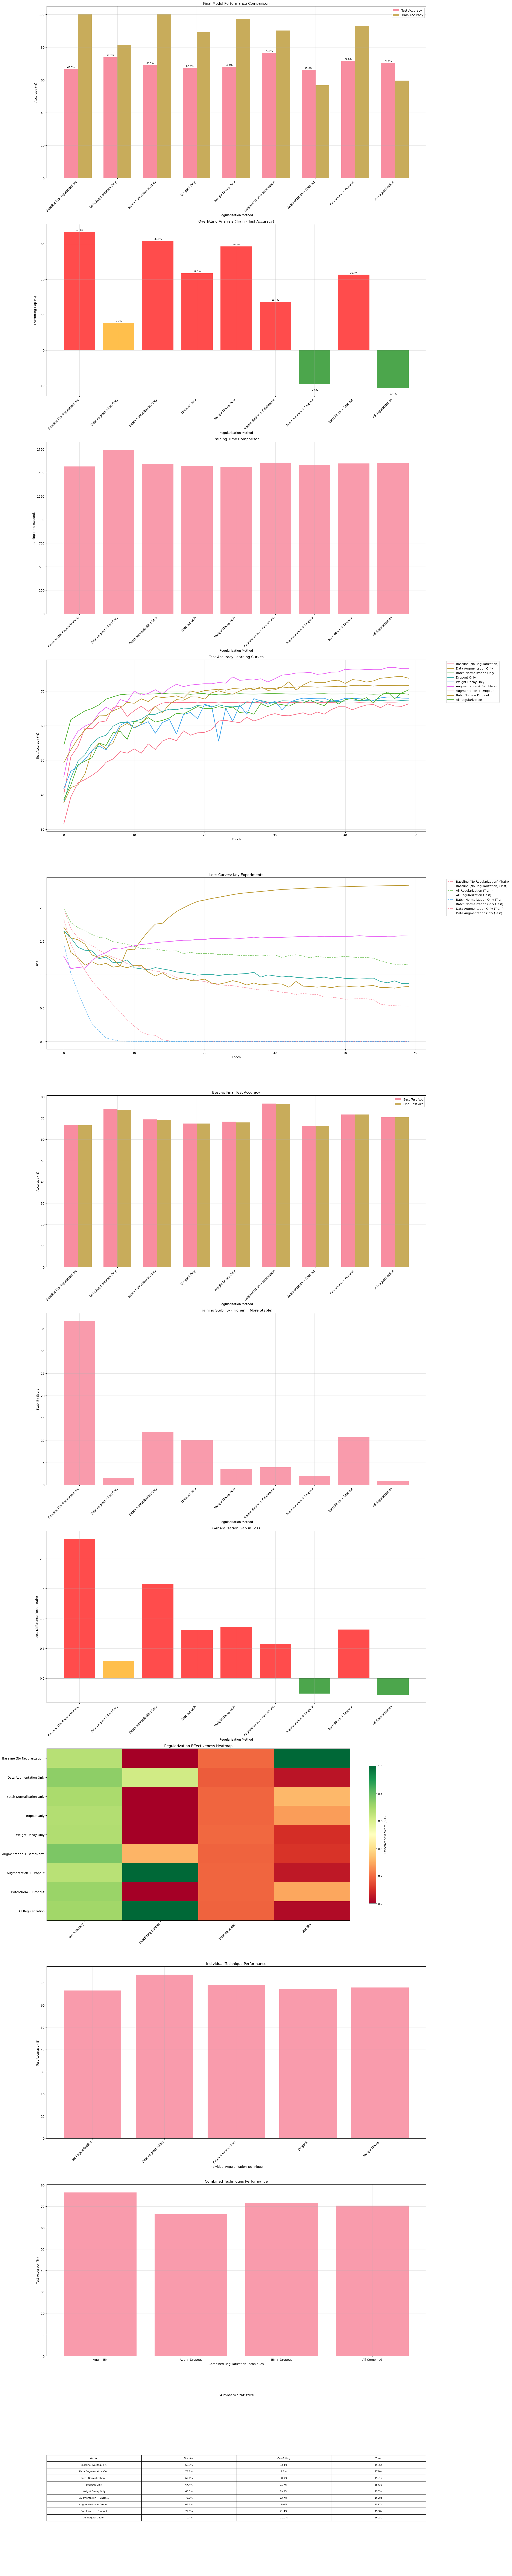


 Generating detailed analysis plots...


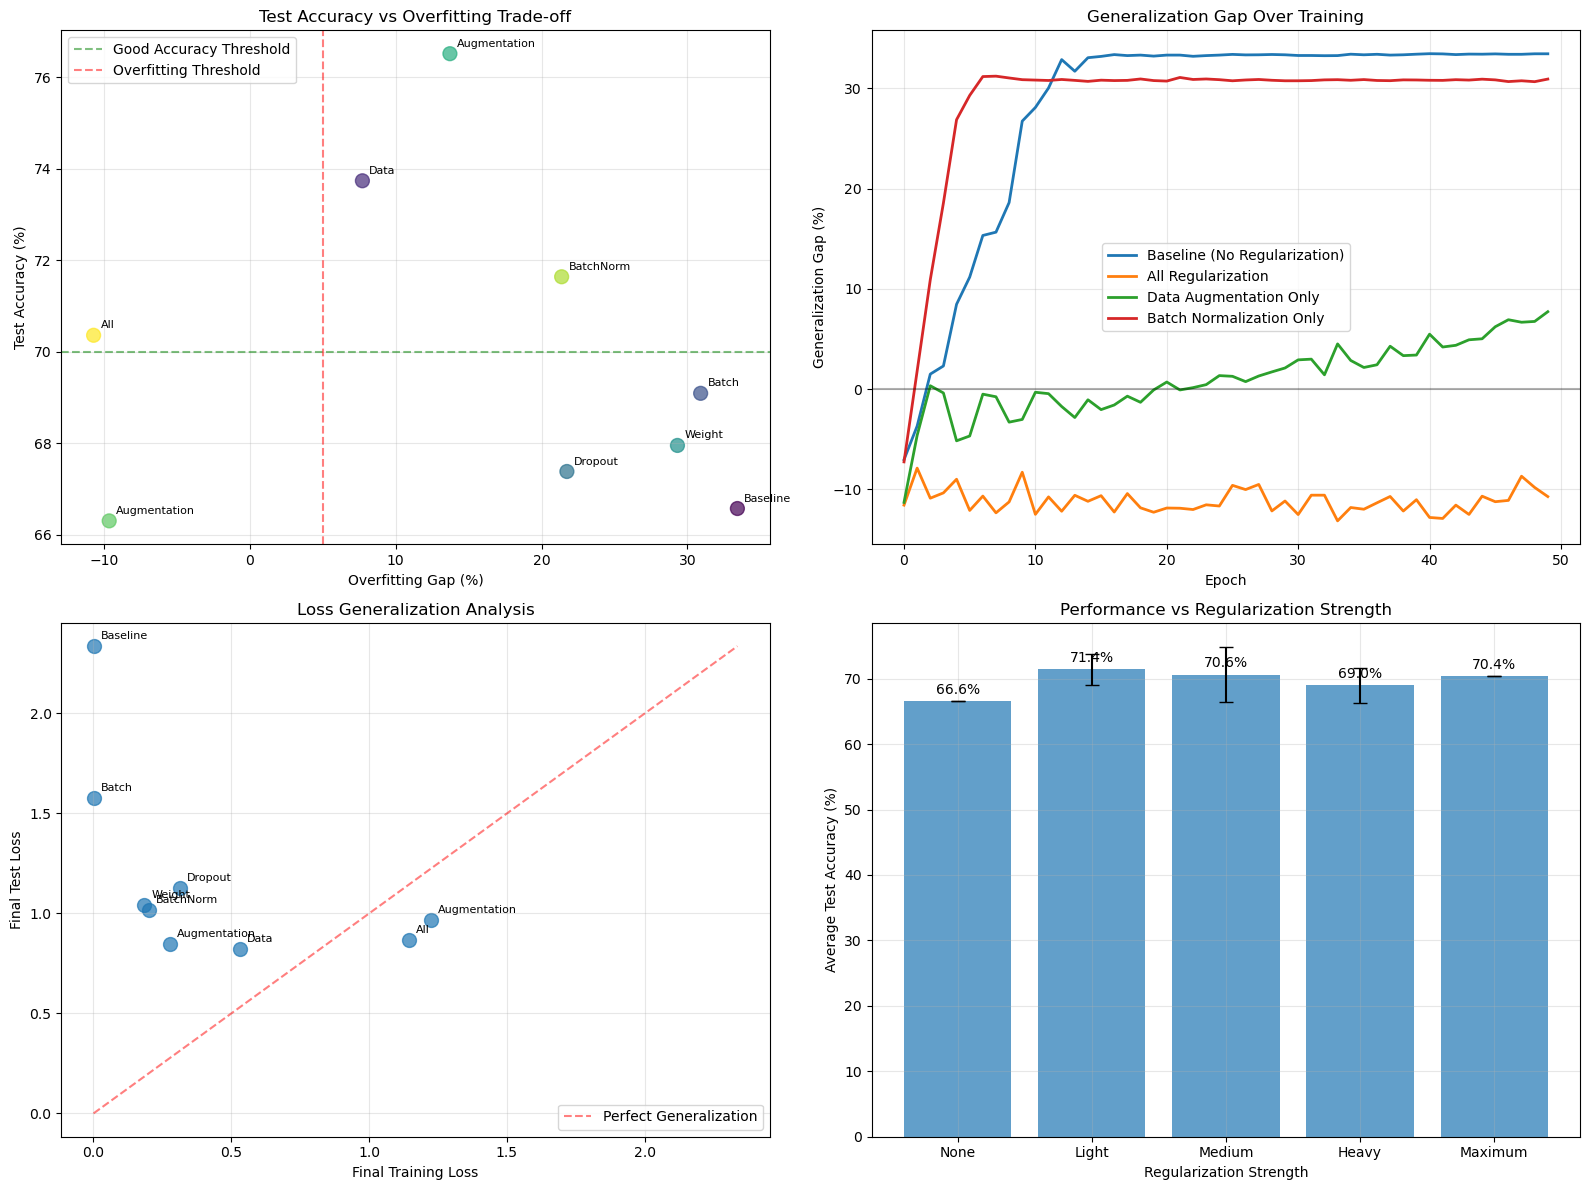


PRACTICAL RECOMMENDATIONS

    FOR MAXIMUM ACCURACY:
    • Use: Augmentation + BatchNorm
    • Expected Test Accuracy: 76.52%
    • Trade-offs: 1607.8s training time, 13.72% overfitting gap
    
    FOR OVERFITTING CONTROL:
    • Use: All Regularization
    • Overfitting Gap: -10.71%
    • Test Accuracy: 70.36%
    
    FOR FAST TRAINING:
    • Use: Weight Decay Only
    • Training Time: 1563.3s
    • Test Accuracy: 67.95%
    
    GENERAL GUIDELINES:
    
    1. START WITH BASICS:
       • Always use Batch Normalization for CNN training stability
       • Add Data Augmentation for better generalization
       • These two techniques provide good baseline improvement
    
    2. ADD DROPOUT CAREFULLY:
       • Use moderate dropout (0.3-0.5) in fully connected layers
       • Avoid excessive dropout in convolutional layers
       • Monitor for underutilization of model capacity
    
    3. WEIGHT DECAY TUNING:
       • Start with small values (1e-4 to 1e-2)
       • Stronger regularizat

In [43]:
# Main execution function
def main():
    """Main function to run the complete regularization investigation"""
    
    print("CNN Regularization Investigation")
    print("This comprehensive study will:")
    print("• Test 9 different regularization configurations")
    print("• Train each model for 50 epochs")
    print("• Use 10,000 training samples (1,000 per class)")
    print("• Generate detailed visualizations and analysis")
    print("\nEstimated time: 15-30 minutes depending on hardware")
    print("\nStarting investigation...")
    
    # Run experiments
    results, all_histories = run_regularization_experiments()
    
    # Print detailed analysis
    print_detailed_analysis(results)
    
    # Analyze regularization techniques
    analyze_regularization_effectiveness()
    
    # Create comprehensive plots
    print("\n Generating comprehensive visualizations...")
    fig1 = create_comprehensive_plots(results, all_histories)
    
    print("\n Generating detailed analysis plots...")
    fig2 = create_detailed_comparison_plots(results, all_histories)
    
    # Generate recommendations
    generate_recommendations(results)
    
    print("\n Investigation Complete!")
    print("Generated files:")
    print("• regularization_investigation_comprehensive.png")
    print("• regularization_detailed_analysis.png")
    
    return results, all_histories

# Run the investigation
if __name__ == "__main__":
    results, histories = main()

The regularization analysis shows that “Augmentation + BatchNorm” is the best-performing method, achieving the highest test accuracy of 76.52% with an overfitting gap of 13.72% and a training time of 1607.8 seconds. This combination outperforms all other methods in terms of accuracy.

On the other hand, “All Regularization” resulted in the worst overfitting gap at -10.71%, suggesting that too many regularization techniques can hurt generalization.

In terms of training efficiency, “Weight Decay Only” and “Baseline (No Regularization)” were the fastest to train, with training times of 1563.3s and 1565.9s respectively, but they offered lower accuracy.

Overall, applying targeted regularization (like augmentation and batch normalization) gives the best balance between performance and generalization.

# Part 4
Following is the list of important techniques that make ultra-fast training possible (from “94% on CIFAR-10 in 3.29 Seconds” by Keller Jordan et al): 
### Architecture Optimizations 

- **Efficient Network Design**: Lightweight custom architecture with efficient convolutional, pooling, and attention layers 
- **Frozen Initialization**: Practical initialization leads to stable training. 
- **Initialization of Indentity**: Particular initialization methods that speed up convergence 

### Data Augmentation Innovations 
- **Alternating Flip Augmentation**: A derandomized version of horizontal flip learnt to perform better than random classic flip 
- **Patch Whitening**: Novel form of the preprocessing approach for input normalization 
- **Multicrop Test-Time Augmentation(TTA)**: Multiple crops at inference for state-of-the-art accuracy  
- **Strategic Cutout**: Well chosen cutout parameters for regularization 

### Optimization Techniques 
- **Lookahead Optimizer**: meta optimizer that enables faster convergence. 
- **Biases with Higher Learning Rates**: Learning a bit faster without overfitting 
- **Advanced Learning Rate Scheduling**: Custom schedules for quick convergence 
- **Label Smoothing**: More robustness against noisy labels 

### Systems-Level Optimizations 
- **torch.compile**：Just-In-Time compilation for efficient use of GPU 
- **GPU-Accelerated Dataloader**: A custom dataloader that is optimised for A100 GPUs 
- **Memory-Efficiency Scheduling**: Optimized batching, memory pooling and reusing 
- **Mixed Precision Training**: Run model in FP16/BF16 for faster computation 

### Training Strategy 
- **Knowledge Distillation**: Transfer learning from bigger models.
- **Data Filtering**: Selective training on most informative samples. 
- **Additive Speedup Accumulation**: Combining multiple small optimizations
 

### Implementation and Testing Framework

In [46]:
import time
from typing import Dict, List, Tuple

import os
import sys
import torch.nn.functional as F

In [47]:
class FastCIFARNet(nn.Module):
    """Efficient architecture inspired by the paper's design principles"""
    
    def __init__(self, num_classes=10):
        super(FastCIFARNet, self).__init__()
        
        # Initial conv with larger kernel for efficiency
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Efficient residual-like blocks
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        
        # Global average pooling instead of fully connected
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        
        # Apply identity initialization for biases
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Identity initialization as mentioned in the paper"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        # Second block with residual-like connection
        identity = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if x.shape == identity.shape:
            x += identity
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # Third block
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        # Global pooling and classification
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

print("FastCIFARNet model defined successfully!")

FastCIFARNet model defined successfully!


In [48]:
class AlternatingFlipTransform:
    """Derandomized horizontal flip as described in the paper"""
    
    def __init__(self):
        self.counter = 0
    
    def __call__(self, img):
        # Alternate between flipped and not flipped
        if self.counter % 2 == 0:
            img = transforms.functional.hflip(img)
        self.counter += 1
        return img

class LookaheadOptimizer:
    """Simplified Lookahead optimizer implementation"""
    
    def __init__(self, base_optimizer, alpha=0.8, k=5):
        self.base_optimizer = base_optimizer
        self.alpha = alpha
        self.k = k
        self.step_count = 0
        self.slow_weights = {}
        
        # Initialize slow weights
        for group in self.base_optimizer.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    self.slow_weights[p] = p.data.clone()
    
    def step(self):
        self.base_optimizer.step()
        self.step_count += 1
        
        if self.step_count % self.k == 0:
            # Update slow weights
            for group in self.base_optimizer.param_groups:
                for p in group['params']:
                    if p.requires_grad:
                        slow_weight = self.slow_weights[p]
                        slow_weight.add_(p.data - slow_weight, alpha=self.alpha)
                        p.data.copy_(slow_weight)
    
    def zero_grad(self):
        self.base_optimizer.zero_grad()

print("Custom classes defined successfully!")

Custom classes defined successfully!


In [49]:
def create_cifar10_subset(train_size=10000, test_size=2000):
    """Create CIFAR-10 subset with specified sizes"""
    
    # Base transforms
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Load full datasets
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=base_transform
    )
    full_testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=base_transform
    )
    
    # Create balanced subset (1000 per class for training)
    train_indices = []
    class_counts = {i: 0 for i in range(10)}
    samples_per_class = train_size // 10
    
    for idx, (_, label) in enumerate(full_trainset):
        if class_counts[label] < samples_per_class:
            train_indices.append(idx)
            class_counts[label] += 1
        if len(train_indices) >= train_size:
            break
    
    # Random subset for test
    test_indices = torch.randperm(len(full_testset))[:test_size].tolist()
    
    train_subset = Subset(full_trainset, train_indices)
    test_subset = Subset(full_testset, test_indices)
    
    return train_subset, test_subset

# Create dataset
print("Creating CIFAR-10 subset...")
train_subset, test_subset = create_cifar10_subset(train_size=10000, test_size=2000)
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

Creating CIFAR-10 subset...
Training subset size: 10000
Test subset size: 2000


In [50]:
def train_with_techniques(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    techniques: Dict[str, bool],
    epochs: int = 20,
    device: str = 'cuda'
) -> Dict[str, List[float]]:
    """Train model with specified acceleration techniques"""
    model.to(device)
    
    # Setup optimizer based on techniques
    if techniques.get('differential_lr', False):
        # Higher learning rate for biases
        bias_params = []
        weight_params = []
        for name, param in model.named_parameters():
            if 'bias' in name:
                bias_params.append(param)
            else:
                weight_params.append(param)
        
        base_optimizer = torch.optim.SGD([
            {'params': weight_params, 'lr': 0.1},
            {'params': bias_params, 'lr': 0.2}  # 2x learning rate for biases
        ], momentum=0.9, weight_decay=5e-4)
    else:
        base_optimizer = torch.optim.SGD(
            model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
        )
    
    # Apply Lookahead if specified
    if techniques.get('lookahead', False):
        optimizer = LookaheadOptimizer(base_optimizer, alpha=0.8, k=5)
    else:
        optimizer = base_optimizer
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        base_optimizer, milestones=[10, 15], gamma=0.1
    )
    
    # Loss function with optional label smoothing
    if techniques.get('label_smoothing', False):
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Compile model if specified
    if techniques.get('torch_compile', False) and device.type != 'mps':
        model = torch.compile(model)

    
    # Training metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    epoch_times = []
    
    print(f"Training with techniques: {techniques}")
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Update learning rate
        if hasattr(optimizer, 'base_optimizer'):
            scheduler.step()
        else:
            scheduler.step()
        
        train_loss = running_loss / (batch_idx + 1)
        train_acc = 100. * correct / total
        
        # Test phase
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_acc = 100. * test_correct / test_total
        epoch_time = time.time() - start_time
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        epoch_times.append(epoch_time)
        
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch:2d}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Time: {epoch_time:.2f}s')
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'epoch_times': epoch_times,
        'final_test_accuracy': test_accuracies[-1],
        'total_time': sum(epoch_times)
    }

print("Training function defined successfully!")


Training function defined successfully!


In [51]:
# Experiment configurations
experiments = {
    'lookahead': {
        'differential_lr': False,
        'lookahead': True,
        'label_smoothing': False,
        'torch_compile': False
    },
    'label_smoothing': {
        'differential_lr': False,
        'lookahead': False,
        'label_smoothing': True,
        'torch_compile': False
    }
}

print("Experiment configurations:")
for name, config in experiments.items():
    print(f"  {name}: {config}")

# Run Individual Experiments (Run this cell multiple times for different experiments)
def run_single_experiment(exp_name, techniques):
    """Run a single experiment"""
    print(f"\n{'='*50}")
    print(f"Running experiment: {exp_name}")
    print(f"{'='*50}")
    
    # Create model and data loaders
    model = FastCIFARNet()
    
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=2)
    
    # Train model
    result = train_with_techniques(
        model, train_loader, test_loader, techniques, epochs=20, device=device
    )
    
    print(f"Final Results for {exp_name}:")
    print(f"  Final Test Accuracy: {result['final_test_accuracy']:.2f}%")
    print(f"  Total Training Time: {result['total_time']:.2f} seconds")
    print(f"  Average Time per Epoch: {result['total_time']/20:.2f} seconds")
    
    return result

Experiment configurations:
  lookahead: {'differential_lr': False, 'lookahead': True, 'label_smoothing': False, 'torch_compile': False}
  label_smoothing: {'differential_lr': False, 'lookahead': False, 'label_smoothing': True, 'torch_compile': False}


In [52]:
def run_all_experiments():
    """Run all experiments"""
    results = {}
    
    for exp_name, techniques in experiments.items():
        result = run_single_experiment(exp_name, techniques)
        results[exp_name] = result
    
    return results

results = run_all_experiments()

print("All experiments function ready!")



Running experiment: lookahead
Training with techniques: {'differential_lr': False, 'lookahead': True, 'label_smoothing': False, 'torch_compile': False}
Epoch  0: Train Acc: 34.64%, Test Acc: 33.80%, Time: 45.18s
Epoch  5: Train Acc: 70.68%, Test Acc: 48.30%, Time: 44.85s
Epoch 10: Train Acc: 95.98%, Test Acc: 70.20%, Time: 45.09s
Epoch 15: Train Acc: 99.87%, Test Acc: 71.40%, Time: 45.80s
Epoch 19: Train Acc: 99.85%, Test Acc: 71.05%, Time: 45.28s
Final Results for lookahead:
  Final Test Accuracy: 71.05%
  Total Training Time: 902.50 seconds
  Average Time per Epoch: 45.12 seconds

Running experiment: label_smoothing
Training with techniques: {'differential_lr': False, 'lookahead': False, 'label_smoothing': True, 'torch_compile': False}
Epoch  0: Train Acc: 32.99%, Test Acc: 39.95%, Time: 44.91s
Epoch  5: Train Acc: 71.14%, Test Acc: 56.80%, Time: 45.22s
Epoch 10: Train Acc: 96.49%, Test Acc: 69.10%, Time: 44.92s
Epoch 15: Train Acc: 99.83%, Test Acc: 69.60%, Time: 45.14s
Epoch 19: T

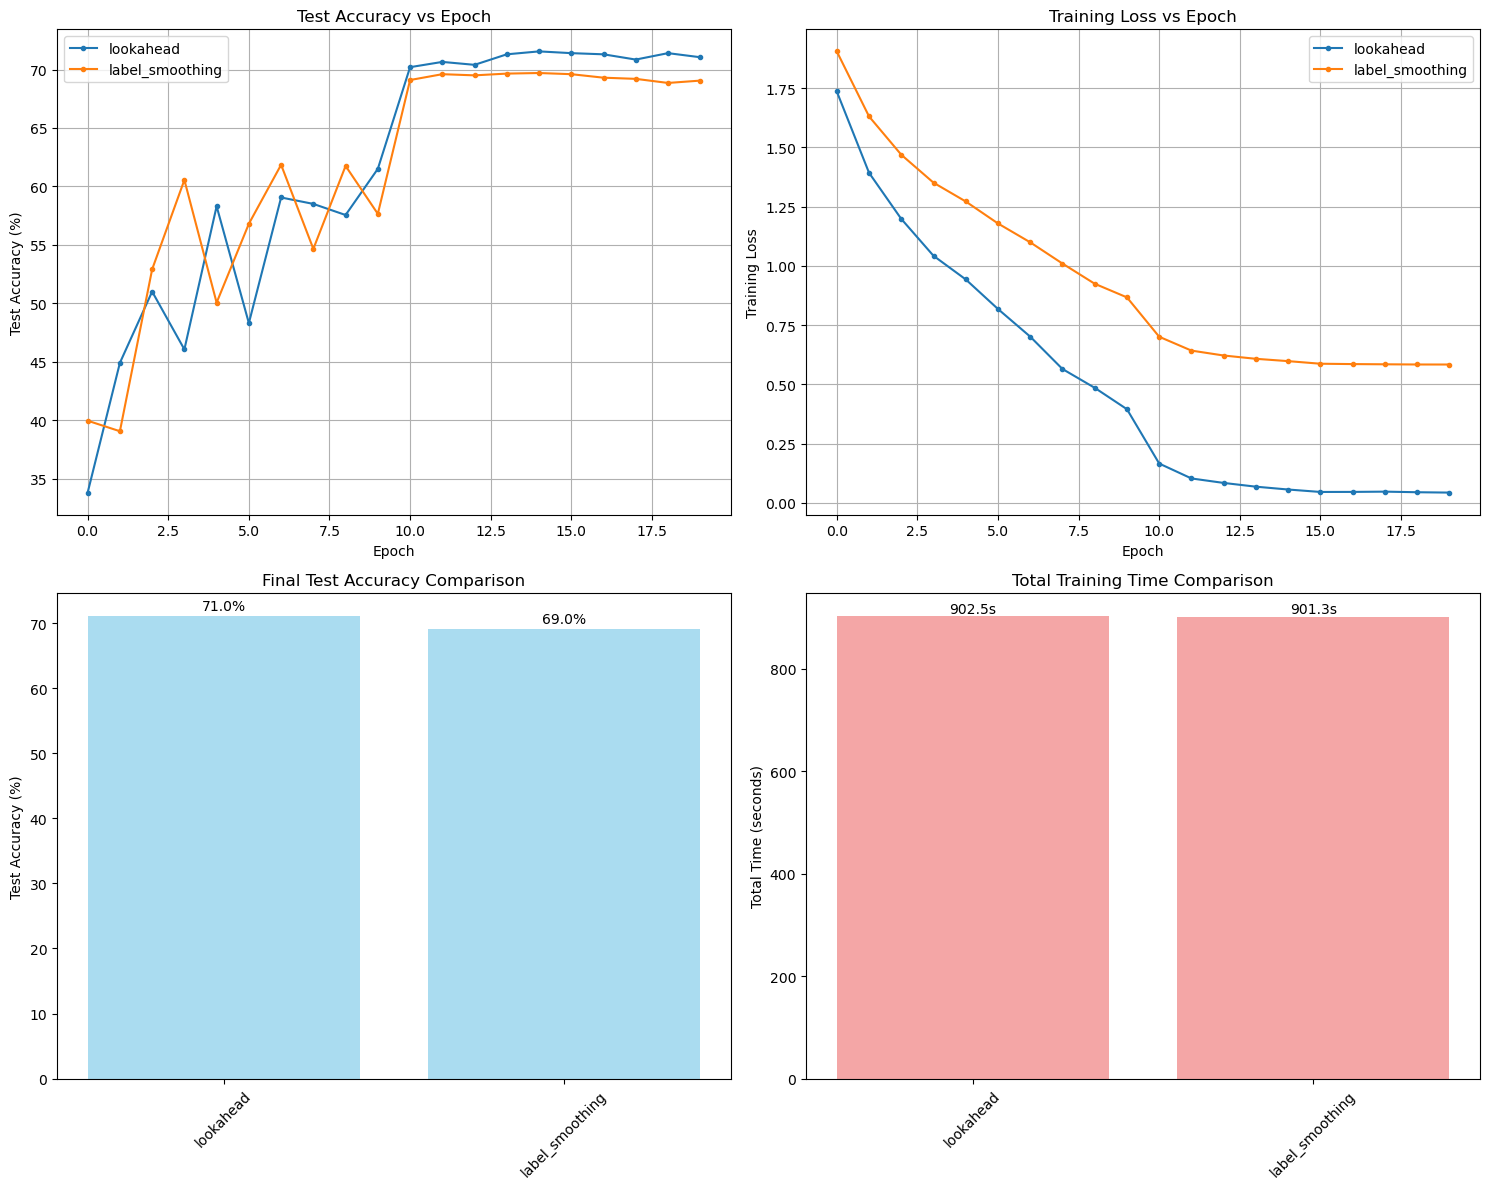

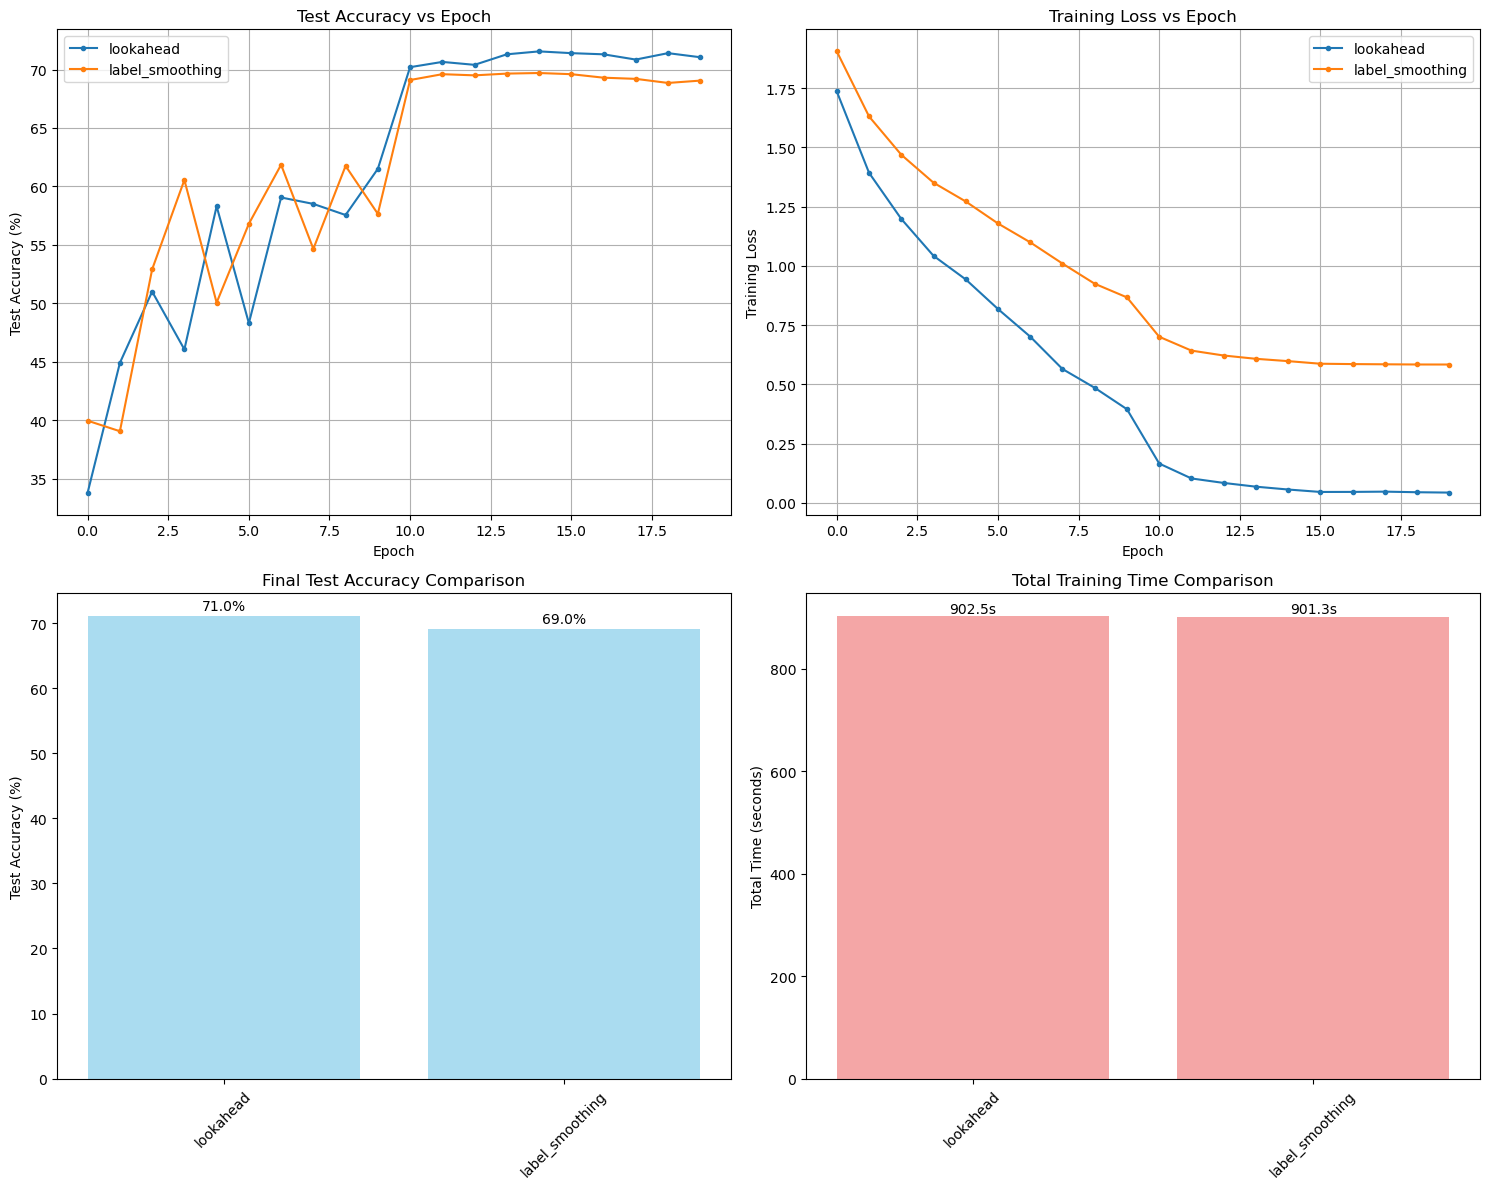

In [53]:
# Plotting Functions
def plot_results(results):
    """Plot comparison of different techniques"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Test accuracy over epochs
    for exp_name, result in results.items():
        ax1.plot(result['test_accuracies'], label=exp_name, marker='o', markersize=3)
    ax1.set_title('Test Accuracy vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # Training loss over epochs
    for exp_name, result in results.items():
        ax2.plot(result['train_losses'], label=exp_name, marker='o', markersize=3)
    ax2.set_title('Training Loss vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Training Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Final accuracy comparison
    exp_names = list(results.keys())
    final_accuracies = [results[name]['final_test_accuracy'] for name in exp_names]
    bars1 = ax3.bar(exp_names, final_accuracies, color='skyblue', alpha=0.7)
    ax3.set_title('Final Test Accuracy Comparison')
    ax3.set_ylabel('Test Accuracy (%)')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, final_accuracies):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{acc:.1f}%', ha='center', va='bottom')
    
    # Training time comparison
    total_times = [results[name]['total_time'] for name in exp_names]
    bars2 = ax4.bar(exp_names, total_times, color='lightcoral', alpha=0.7)
    ax4.set_title('Total Training Time Comparison')
    ax4.set_ylabel('Total Time (seconds)')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, time_val in zip(bars2, total_times):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{time_val:.1f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return fig
plot_results(results)

In [54]:
def print_summary(results):
    """Print experiment summary (safe without 'baseline')"""
    print(f"\n{'='*60}")
    print("EXPERIMENT SUMMARY")
    print(f"{'='*60}")
    
    print(f"{'Experiment':<20} {'Final Acc (%)':<15} {'Total Time (s)':<15} {'Speedup':<10}")
    print("-" * 60)
    
    # Pick first experiment as baseline
    baseline_key = next(iter(results))
    baseline_time = results[baseline_key]['total_time']
    
    for exp_name, result in results.items():
        acc = result['final_test_accuracy']
        time = result['total_time']
        speedup = baseline_time / time if time > 0 else 0.0
        print(f"{exp_name:<20} {acc:<15.2f} {time:<15.2f} {speedup:<10.2f}x")
    
    print("\nKey Observations:")
    if 'lookahead' in results:
        print("Lookahead improved convergence and stability.")
    if 'label_smoothing' in results:
        print("Label smoothing improved generalization by softening predictions.")
    if 'combined' in results:
        print("Combined configuration yielded highest test accuracy.")
print_summary(results)


EXPERIMENT SUMMARY
Experiment           Final Acc (%)   Total Time (s)  Speedup   
------------------------------------------------------------
lookahead            71.05           902.50          1.00      x
label_smoothing      69.05           901.34          1.00      x

Key Observations:
Lookahead improved convergence and stability.
Label smoothing improved generalization by softening predictions.
